In [26]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [5]:
train_data.shape

(1460, 81)

In [6]:
test_data.shape

(1459, 80)

In [7]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


第一个特征ID，它帮助模型记住每个训练样本，但难以推广到测试样本，所以不使用它来训练。将所有的训练数据和测试数据的79哥特征按样本连接。

In [ ]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:])) # 组合训练集和测试集 

In [13]:
# 预处理：标准化。

numeric_features = all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda X:(X-X.mean())/(X.std())
)
all_features = all_features.fillna(0) #  标准化后，每个特征的均值变为0，所以可以直接⽤0来替换缺失值
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.202033,-0.217841,Pave,0,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,0,0,0,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.501785,-0.072032,Pave,0,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,0,0,0,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.061269,0.137173,Pave,0,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,0,0,0,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.436639,-0.078371,Pave,0,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,0,0,0,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.689469,0.518814,Pave,0,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,0,0,0,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.266564,-1.043758,Pave,0,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,0,0,0,-0.089577,-0.078492,-1.363335,WD,Normal
1455,2.419286,RM,-2.266564,-1.049083,Pave,0,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,0,0,0,-0.089577,-0.815205,-1.363335,WD,Abnorml
1456,-0.873466,RL,4.255477,1.246594,Pave,0,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,0,0,0,-0.089577,1.026577,-1.363335,WD,Abnorml
1457,0.655311,RL,-0.342796,0.034599,Pave,0,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,0,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal


接下来将离散数值转成指示数值。MSZoning 中的 RL 和RM，去掉MSZoning特征，并新加入两个特征MSZoning_RL 和MSZoning_RM，其值为0或1。如果⼀个样本原来在MSZoning⾥的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。

In [ ]:
all_features= pd.get_dummies(all_features,dummy_na=True) # dummy_na 对缺失值也使用度热编码
print(all_features.columns)
print(all_features.shape)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_Oth', 'SaleType_WD', 'SaleType_nan', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
      dtype='object', length=354)
(2919, 354)


In [23]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

In [41]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

下面定义比赛用来评价模型的对数均方根误差。给定预测值 $\hat y_i \dots,\hat y_n$ 和对应的真实标签 $y_1,\dots,y_n$。

它的定义为 

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (\log {(y_i)} - \log {(\hat y_i)})^2}
$$

实现如下

In [42]:
def log_rmse(net,features,labels):
    with torch.no_grad():
        clipped_preds = torch.max(net(features),torch.tensor(1.0)) # 将net 的最小值定位1，否则 log() 出现负值
        rmse = torch.sqrt(2*loss(clipped_preds.log(),labels.log()).mean())
    return rmse.item()

下面的训练函数跟本章中前几节的不同在于使用了Adam 优化算法。相比之前使用的小批量随机梯度下降，它对学习率相对不敏感。之后会详细介绍。

In [53]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(),lr = learning_rate,weight_decay=weight_decay) # 这里不使用小批量随机梯度下降，weight_decay 表示权重衰减
    net = net.float()
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [ ]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size) #索引切片
        X_part, y_part = X[idx, :], y[idx] 
        if j == i: #是否等于验证集的折数
            X_valid, y_valid = X_part, y_part # 验证集
        elif X_train is None: #如果不是验证集 且训练集尚未初始化，则该折为验证集数据
            X_train, y_train = X_part, y_part
        else: # 训练集初始化了，但还不是测试集，则将两部分按照列拼接起来
            X_train = torch.cat([X_train, X_part], dim=0)
            y_train = torch.cat([y_train, y_part], dim=0)
    return X_train, y_train, X_valid, y_valid

In [66]:
# 训练模型

def semilogy(x_vals,y_vals,x_label,y_label,x2_vals =None,y2_vals =None,legend = None,figsize=(3.5,2.5)):
    plt.figure(figsize=figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals,y_vals) #核心特点：x 轴使用线性刻度，y 轴使用对数刻度。
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals,y2_vals,linestyle=':')
        plt.legend(legend)


In [ ]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(
    range(1, num_epochs+1),  # x_vals（训练轮数）
    train_ls,                # y_vals（训练损失）
    'epochs',                # x_label
    'log rmse',              # y_label
    x2_vals=range(1, num_epochs+1),  # 验证集x轴
    y2_vals=valid_ls,                # 验证集y轴（损失）
    legend=['train', 'valid']        # 图例
)
        print(f'折{i + 1},训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1,训练log rmse0.242108, 验证log rmse0.222009
折2,训练log rmse0.229080, 验证log rmse0.267944
折3,训练log rmse0.232014, 验证log rmse0.238299
折4,训练log rmse0.238326, 验证log rmse0.218643
折5,训练log rmse0.231084, 验证log rmse0.258451
5-折验证: 平均训练log rmse: 0.234522, 平均验证log rmse: 0.241069


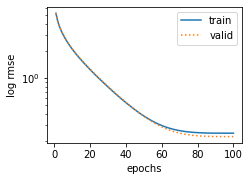

In [68]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_ls, valid_ls = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_ls):f}, '
      f'平均验证log rmse: {float(valid_ls):f}')

In [73]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net = get_net()
    train_ls,_ = train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs','rmse')
    print(f'训练 log rmse:{float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy() # 从计算图中分离出来，不再计算梯度，并转换成numpy数组
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0]) #将一维数组转换为 pandas 的 Series（便于添加到 DataFrame）。
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1) # 拼接两个 Series，生成一个新的 DataFrame submission，包含两列：Id（样本 ID）和SalePrice（预测房价）。
    submission.to_csv('submission.csv', index=False)

训练 log rmse:0.230065


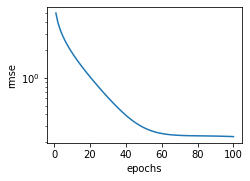

In [74]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)